# Predicting Heart Attacks in Patients

In this element, I am building  supervised learning algorithms to predict whether an individual is going to have a heart attack or not based on various factors. Unlike in the supervised learning element, I am not building these models from scratch, instead I will be using the sklearn implementations. My goal is to choose the best model for this task. 

I start by importing all the necessary packages.

In [1]:
## Import block
import numpy as np
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
from sklearn.cluster import KMeans 

import timeit

/Users/sashayeutseyeva/opt/anaconda3/envs/csc294/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


## Data Selection and Importing

The data I will be using is the heart attack prediction dataset found on [Kaggle](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). Due to the nature of medical data, this data came from a confidential source so no knowledge is known about this dataset. The variables of this dataset are:
- age: The age of the patient.
- sex: The sex of the patient.
- cp: The chest pain type, where 1 is typical angina, 2 is atypical angina, 3 is non-anginal pain, and 4 is asymptomatic.
- trtbps: The resting blood pressure, in mm Hg.
- chol: The cholestoral in mg/dl of the patient fetched via BMI sensor.
- fbs: Whether the fasting blood sugar is greater than greater than 120 mg/dl (indicated by 1) or smaller than (indicated by 0).
- restecg: The resting electrocardiographic results of the patient. 0 is normal, 1 is having an abnormality, and 2 is showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalachh: The maximum heart rate achieved.
- exng: Whether the patient had exercise induced angina (1 = yes and 0 = no)
- oldpeak: No description given
- slp: No description given
- caa: The number of major vessels (0, 1, or 3)
- thall: No description given
- output: Whether the patient had a heart attack or not


Using this data, I am attempting to answer if it can be predicted whether an individual is having a heart attack. In other words, by looking at all this information, or certain variables, about a person, can they be classified as having a heart attack or not? This question falls under the classification task, since in the end the individuals are classified into one of two groups, heart attack victim or not. This is not clustering because when testing the predictions, there is only one true answer for the value of 'output'.

In [2]:
#importing all the data files
data_pd = pd.read_csv("heart.csv", sep = ",")

data_pd.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


To make my models, I will be using age, cholesterol level, resting blood pressure and maximum heart rate achieved. I am choosing to focus on these variables because of previous [research](https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack) that confirms these variables are all associated with heart attack. As a result, I want to drop all other variables for simplicity.

In [3]:
#Dropping unecessary variables and observations containing null values
data_pd = data_pd.drop(labels = ['sex','cp','fbs','restecg','exng','oldpeak','slp','thall','caa'], axis = 1)
data_pd = data_pd.dropna(axis=0)

data_pd

,age,trtbps,chol,thalachh,output
0,63,145,233,150,1
1,37,130,250,187,1
2,41,130,204,172,1
3,56,120,236,178,1
4,57,120,354,163,1
...,...,...,...,...,...
298,57,140,241,123,0
299,45,110,264,132,0
300,68,144,193,141,0
301,57,130,131,115,0


Finally, I want to shuffle my data so that not all the heart attack victims are at the top. This helps with division of cross validation.

In [4]:
df_random = data_pd.sample(frac=1,random_state=15)

df_random

,age,trtbps,chol,thalachh,output
201,60,125,258,141,0
197,67,125,254,163,0
64,58,140,211,165,1
134,41,126,306,163,1
145,70,156,245,143,1
...,...,...,...,...,...
199,65,110,248,158,0
155,58,130,197,131,1
156,47,130,253,179,1
133,41,110,235,153,1


Now that my dataset is ready, I can convert it to a numpy array and divide the data between rows for cross validation and the validation set. I am reserving 20 percent of the data for the validation set because it is a fairly small dataset with only 303 observations, so a larger validation set helps to produce a more accurate mean squared error.

In [5]:
#data_np created to use for models and dividing data
data_np = df_random.to_numpy()

#Dividing data for cross validation and for validation
end_point_data = len(data_np)//10*8

CV_data = data_np[0:end_point_data,:]
validation_data = data_np[end_point_data:,:]

To help me assess the effectiveness of my models, I write a function that computes the mean squared error for two vectors.

In [6]:
# a function to help compute the MSE for two vectors
def compute_mse(truth_vec, predict_vec):
    return np.mean((truth_vec - predict_vec)**2)

## Building Models

### Decision Tree

I have decided to use a decision tree as my first model because the four variables used to classify people as heart attack victims or not can be intuitively split up into various decisions. The incremental nature of the age, resting blood pressure, cholesterol, and maximum heart rate ensure the decision tree would not be able to split off with too many possibilities for each node. Furthermore, the fitted decision tree could show which variables are the most important, depending on which variables are represented in the decisions of each node. 

For simplicity, I will determine the best max_depth for the tree, choosing between 2, 3, and 5. I will implement 5 fold cross validation.

In [7]:
#5 fold cross validation for different number of depths for decision tree
def dt_CV(data,max_depth):
    
    divisor_num = 5
    
    data_divisor = len(data)//divisor_num
    test_errors = []

    for i in range (0,divisor_num):
        #splits data into testing and training, if on 10th part of data, takes remaining section of data
        if i != divisor_num-1:
            training_data = np.delete(data,slice(i*data_divisor,i*data_divisor+data_divisor),0)
            testing_data = data[i*data_divisor:i*data_divisor+data_divisor,:]
        else:
            training_data = np.delete(data,slice(i*data_divisor-1,-1),0)
            testing_data = data[i*data_divisor-1:-1,:]
        
        #assigns in classes and out classes for kNN to be fitted to
        in_classes = training_data[:,0:4]
        out_class = training_data[:,4]
        
        #defining the algorithm
        dt = DecisionTreeClassifier(max_depth = max_depth)
        
        #fitting the algorithm to the training data
        dt.fit(in_classes, out_class)
        
        #predicting values for the testing data
        all_labels = dt.predict(testing_data[:,0:4])
        
        #computing the MSE and appending it to the list of all errors
        test_error = compute_mse(testing_data[:,4],all_labels)
        test_errors.append(test_error)
    
    #returns the average MSE for kNN with a specified number of neighbours
    return np.mean(test_errors)

In [8]:
# display results of cross validation for various parameters
print("The CVE for a decision tree with depth 2 is:",dt_CV(CV_data,2))
print("The CVE for a decision tree with depth 3 is:",dt_CV(CV_data,3))
print("The CVE for a decision tree with depth 5 is:",dt_CV(CV_data,5))

The CVE for a decision tree with depth 2 is: 0.35
The CVE for a decision tree with depth 3 is: 0.36250000000000004
The CVE for a decision tree with depth 5 is: 0.39166666666666666


Since having a depth of 2 gave the lowest means squared error, I will use a decision tree with a max depth of 2 for my first model.

### kNN

I have decided to use the kNN algorithm because it can classify datasets into multiple classes (for this dataset I only need it to classify each point into one of two classes), and it also works well with numerical data. There is also flexibility with the number of nearest neighbors to consult for determining a classification.

To choose the appropriate number of neighbors for kNN, I will determine the cross validated error for 1,3, and 5 neighbours, choosing the lowest one for my final number of neighbours. I will use 5 fold cross validation to determine the cross-validated error for each number of neighbors. Since the dataset is fairly small, I do not want to make each batch of training data so small the algorithm will be ineffective.


In [9]:
#5 fold cross validation for different number of neighbors for kNN
def kNN_CV(data,n_neighbors):
    
    data_divisor = len(data)//5
    test_errors = []

    for i in range (0,5):
        #splits data into testing and training, if on 10th part of data, takes remaining section of data
        if i != 4:
            training_data = np.delete(data,slice(i*data_divisor,i*data_divisor+data_divisor),0)
            testing_data = data[i*data_divisor:i*data_divisor+data_divisor,:]
        else:
            training_data = np.delete(data,slice(i*data_divisor-1,-1),0)
            testing_data = data[i*data_divisor-1:-1,:]
        
        #assigns in classes and out classes for kNN to be fitted to
        in_classes = training_data[:,0:4]
        out_class = training_data[:,4]
        
        #defining the algorithm
        kNN_alg = KNeighborsClassifier(n_neighbors=n_neighbors)
        
        #fitting the algorithm to the training data
        kNN_alg.fit(in_classes,out_class)
        
        #predicting values for the testing data
        all_labels = kNN_alg.predict(testing_data[:,0:4])
        
        #computing the MSE and appending it to the list of all errors
        test_error = compute_mse(testing_data[:,4],all_labels)
        test_errors.append(test_error)
    
    #returns the average MSE for kNN with a specified number of neighbours
    return np.mean(test_errors)
        

In [10]:
# display results of cross validation for various parameters
print("The CVE for kNN with 1 neighbor is:",kNN_CV(CV_data,1))
print("The CVE for kNN with 3 neighbor is:",kNN_CV(CV_data,3))
print("The CVE for kNN with 5 neighbor is:",kNN_CV(CV_data,5))

The CVE for kNN with 1 neighbor is: 0.4708333333333333
The CVE for kNN with 3 neighbor is: 0.3833333333333333
The CVE for kNN with 5 neighbor is: 0.3875


Since having 3 nearest neighbours gave the lowest means squared error, I will use kNN with 3 neighbors as my second model.

## Building the models

To choose the best model, I will evaluate their mean squared error values as well as time both implementations to see how long each takes to run. 

For the decision tree, the optimal max depth I chose was 2. This time, I fit the tree to my entire CV dataset. I also utilize the timeit module to measure how long the process takes. 

In [11]:
%%timeit
#defining the algorithm
dt = DecisionTreeClassifier(max_depth = 2)

#fitting the algorithm to the training data
dt.fit(CV_data[:,0:4], CV_data[:,4])

299 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
#defining the algorithm
dt = DecisionTreeClassifier(max_depth = 2)

#fitting the algorithm to the training data
dt.fit(CV_data[:,0:4], CV_data[:,4])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Timeit ran this block multiple times to find the average time it took per loop, which was 308 microseconds. This is pretty quick, but it's important to compare it to the runtime of kNN.

Now, since decision trees have a cool package where I can visualize it, I can create an image that visualizes the actual decisions of the tree. 

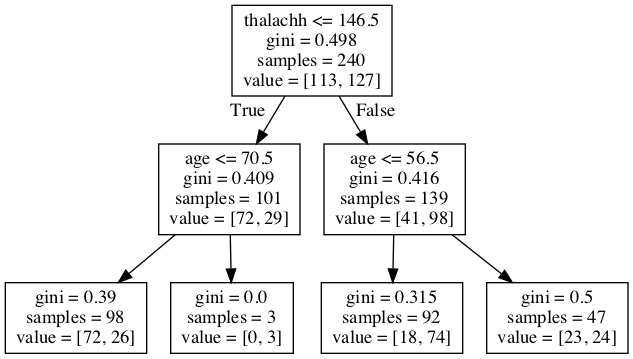

In [13]:
var_names = list(data_pd.columns)[0:4]

dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

It appears that the maximum heart rate achieved and age were very significant variables and were used to build the tree since those were the only two variables used. 

Now, I build my kNN model with 3 neighbours, timing it in the same way I timed the decision tree:

In [14]:
%%timeit
#defining the algorithm
kNN_alg = KNeighborsClassifier(n_neighbors=3)
        
#fitting the algorithm to the training data
kNN_alg.fit(CV_data[:,0:4], CV_data[:,4])

225 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
#defining the algorithm
kNN_alg = KNeighborsClassifier(n_neighbors=3)
        
#fitting the algorithm to the training data
kNN_alg.fit(CV_data[:,0:4], CV_data[:,4])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

It appears as though kNN is quiker when it comes to defining the algorithm and fitting the data, with an average time of 222 microseconds. For now, kNN is the better choice, but the time it takes to predict the new values as well as the mean sum of squares must still be calculated.

## Testing on the Validation Set

To test on the validation set, I will be running my algorithms, which have been fitted to the rest of the data, and comparing the results to the actual values of the 'output' variable of the validation set through a computation of the mean squared error. I will also be timing how long each takes to predict.

In [16]:
%%timeit
#predicting values for the decision tree
all_labels_decision_tree = dt.predict(validation_data[:,0:4])


55.6 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
#predicting values for the decision tree
all_labels_kNN = kNN_alg.predict(validation_data[:,0:4])


1.88 ms ± 69.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Evidently, the decision tree is much faster at predicting values for the data, taking only 52 microseconds, compared to 1.81 ms for kNN. This may be because it does so by following a few logical questions, achieving the final result quickly. On the other hand, kNN needs to compute the nearest neighbours of all the points, which is costly in time. However, if kNN has a much higher degree of accuracy, indicayed by a smaller MSE, the kNN might be the better choice. 

Now, to compute the MSE for both algorithms, which will actually show us the effectiveness of both algorithms.

In [18]:
all_labels_decision_tree = dt.predict(validation_data[:,0:4])
all_labels_kNN = kNN_alg.predict(validation_data[:,0:4])

dt_MSE = compute_mse(validation_data[:,4],all_labels_decision_tree)
kNN_MSE = compute_mse(validation_data[:,4],all_labels_kNN)

print("The mean squared error for the decision tree is:",dt_MSE)
print("The mean squared error for kNN is:",kNN_MSE)

The mean squared error for the decision tree is: 0.2698412698412698
The mean squared error for kNN is: 0.38095238095238093


With a mean squared error of only 0.27, and a running time that greatly outperforms kNN's, the decision tree is the obvious choice for this dataset. 

Although the decision tree is the better choice, I would not call it an extremely effective model, given an MSE of 0.27. However, for something as complex and varied as the biological phenomenon of a heart attack, I guess it may be hard to consult only a few variables to give the correct diagnosis. I am glad that currently, we still have human doctors who do this, instead of machine learning algorithms. However, models like these, although simplified, could be used in the future for applications like these.

#### Resources consulted 

0. [time vs timeit](https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit)
1. [Heart Attack Dataset]()